In [90]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.densenet import DenseNet121 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D 
from tensorflow.keras.models import Model 
from tensorflow.keras import backend as K 
from tensorflow.keras.models import load_model
import os, sys
import cv2
%matplotlib inline

In [91]:
ROOT_DIR = 'E:\\PROJECTS AND CODES\\AI AND DATA SCIENCE\\DATA-SETS\\ranzr-clip-placement'
DATA_SETS = ROOT_DIR + '\\datasets'
SCRIPTS = ROOT_DIR + '\\scripts'

In [92]:
datasets_list = os.listdir(DATA_SETS)
datasets_list

['sample_submission.csv',
 'test',
 'test_tfrecords',
 'train',
 'train.csv',
 'train_annotations.csv',
 'train_tfrecords']

In [93]:
train = os.path.join(DATA_SETS, 'train')
submission_csv = os.path.join(DATA_SETS,'sample_submission.csv')
test = os.path.join(DATA_SETS, 'test')

In [94]:
train_df = pd.read_csv(DATA_SETS+'\\train.csv')
print(f'Train Data CSV: {train_df.shape[0]}')
train_df.head()

Train Data CSV: 30083


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


In [95]:
sub_df = pd.read_csv(submission_csv)
print(f'Sub CSV: {sub_df.shape[0]}')
sub_df.head()

Sub CSV: 3582


,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present
0,1.2.826.0.1.3680043.8.498.46923145579096002617...,0,0,0,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.8.498.84006870182611080091...,0,0,0,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.8.498.12219033294413119947...,0,0,0,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.8.498.84994474380235968109...,0,0,0,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.8.498.35798987793805669662...,0,0,0,0,0,0,0,0,0,0,0


In [96]:
# label column names
label_cols = list(sub_df.columns[1:])
image_labels = train_df[label_cols].values # will be used for train validation splitting

In [97]:
# Count up the number of instances of each class (drop non-class columns from the counts) 
class_counts = train_df.sum().drop(['StudyInstanceUID','PatientID'])

In [98]:
# we plot the distribution of patients to check if there is any class imbalance in the dataset
def plot_class_distributions(values, index):
    sns.barplot(x=values, y=index)
    plt.title('Distribution of classes for the patients')
    plt.xlabel('Patient Count', fontsize=15)
    plt.ylabel('Catheter Position', fontsize=15)
    plt.show()

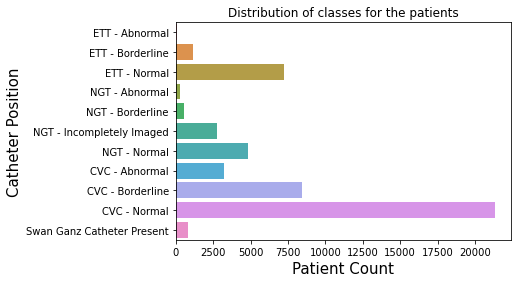

In [99]:
plot_class_distributions(class_counts.values, class_counts.index)

In [100]:
train_images = ROOT_DIR + "\\train\\" + train_df['StudyInstanceUID'] + '.jpg'   
test_images = ROOT_DIR + "\\test\\" + sub_df['StudyInstanceUID'] + '.jpg'
train_images.head()

0    E:\PROJECTS AND CODES\AI AND DATA SCIENCE\DATA...
1    E:\PROJECTS AND CODES\AI AND DATA SCIENCE\DATA...
2    E:\PROJECTS AND CODES\AI AND DATA SCIENCE\DATA...
3    E:\PROJECTS AND CODES\AI AND DATA SCIENCE\DATA...
4    E:\PROJECTS AND CODES\AI AND DATA SCIENCE\DATA...
Name: StudyInstanceUID, dtype: object

In [101]:
data_image = os.path.join(DATA_SETS, "train_annotations.csv")
data_image = pd.read_csv(data_image)
data_image.head()

,StudyInstanceUID,label,data
0,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1487, 1279], [1477, 1168], [1472, 1052], [14..."
1,1.2.826.0.1.3680043.8.498.12616281126973421762...,CVC - Normal,"[[1328, 7], [1347, 101], [1383, 193], [1400, 2..."
2,1.2.826.0.1.3680043.8.498.72921907356394389969...,CVC - Borderline,"[[801, 1207], [812, 1112], [823, 1023], [842, ..."
3,1.2.826.0.1.3680043.8.498.11697104485452001927...,CVC - Normal,"[[1366, 961], [1411, 861], [1453, 751], [1508,..."
4,1.2.826.0.1.3680043.8.498.87704688663091069148...,NGT - Normal,"[[1862, 14], [1845, 293], [1801, 869], [1716, ..."


In [102]:
# display images randomly on a grid
def display_images(image_ids, labels):
    fig = plt.figure(figsize = (16,12))
    
    for index, (image_id, label) in enumerate(zip(image_ids,labels)):
        plt.subplot(3,3, index+1)
        image = image_id + '.jpg'
        image = mpimg.imread(os.path.join(DATA_SETS, "train", image))
        plt.title(label, fontsize=12)
        plt.imshow(image,cmap='Greys')
    
    fig.tight_layout()
    plt.show()    
        

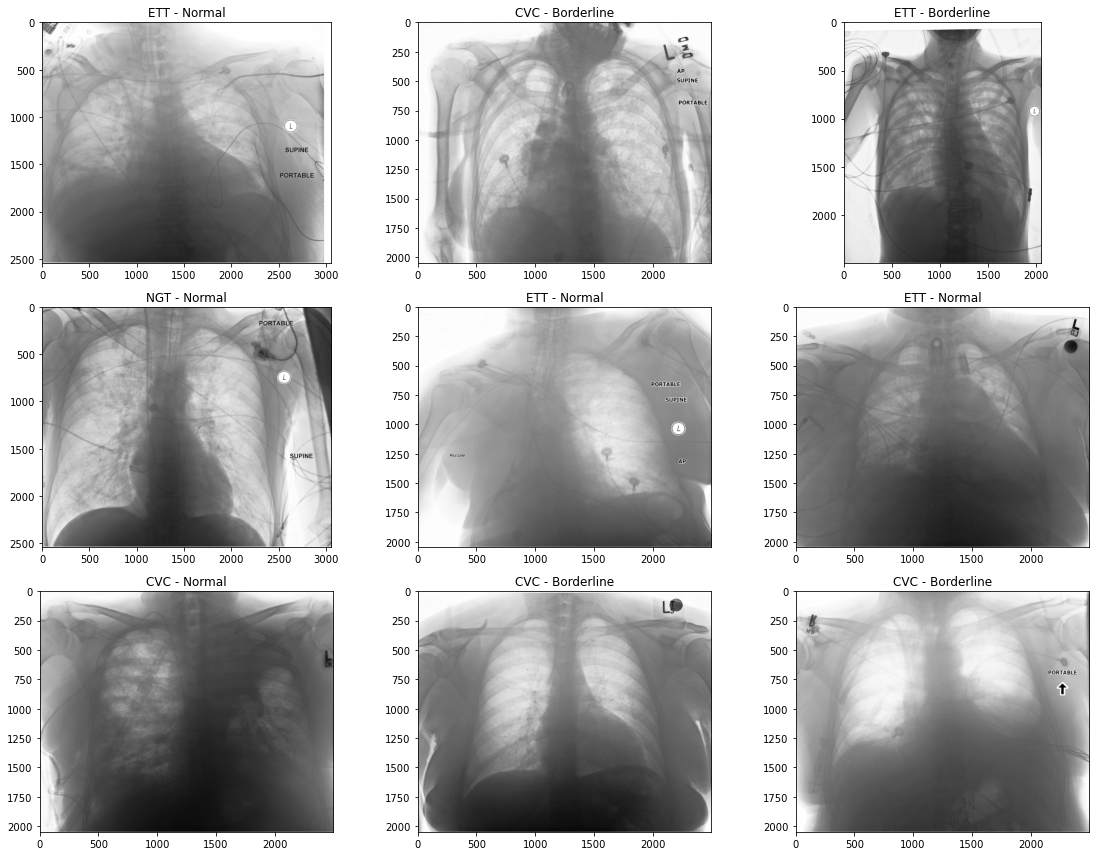

In [103]:
tmp_train = data_image.sample(9)
image_ids = tmp_train["StudyInstanceUID"].values
labels = tmp_train['label'].values
display_images(image_ids, labels)

In [104]:
# now we check for any kinds of data leakage between any two data sets, train-test, train-valid, valid-test
def check_for_leakage(df1, df2, patient_col):
    
    df1_unique = set(df1[patient_col])
    df2_unique = set(df2[patient_col])
    
    common_patients = df1_unique.intersection(df2_unique)
    
    return True if len(common_patients) > 0 else False
    
    

In [105]:
def print_unique_value(df, column_name):
    print('The Unique value for the column {} is: {}'.format(column_name, len(set(df[column_name]))))

In [106]:
check_for_leakage(train_df, sub_df, "StudyInstanceUID")

False

In [107]:
# unique valus in the train dataset
print_unique_value(train_df, 'PatientID')

The Unique value for the column PatientID is: 3255


In [108]:
# splitting into train and validation data sets
train_df_splitted, valid_df = train_test_split(train_df, test_size = 0.1, shuffle=True)

In [109]:
print_unique_value(train_df_splitted, 'PatientID')
print_unique_value(valid_df, 'PatientID')

The Unique value for the column PatientID is: 3210
The Unique value for the column PatientID is: 1506


In [110]:
check_for_leakage(train_df_splitted, valid_df, 'PatientID')

True

In [111]:
TRAIN_IMAGE_DIR = DATA_SETS + '\\train\\'
TEST_IMAGE_DIR = DATA_SETS + '\\test\\'

In [112]:
# without augmentation
def get_train_generator(df, image_dir, image_id, label_names, shuffle=True, batch_size=32, seed=1, target_width=256, target_height=256):
    print('Train Generator Preparation: ')
    
    # first we normalize the images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization=True
    )
    
    # next we flow from data frame with a certain batch size.
    # This flows the images from the directory
    generator = image_generator.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode="raw",
        classes=label_names,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=1,
        target_size=(target_width, target_height)
    )
    
    return generator
    

In [113]:
# create image generator
def get_image_generator(train_df, image_dir, image_id, label_names, shuffle=True, batch_size=32, seed=1, target_width=256, target_height=256, sample_size=100):
    # generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        directory=image_dir,
        x_col=image_id,
        y_col=label_names,
        class_mode='raw',
        batch_size=sample_size,
        shuffle=shuffle,
        target_size=(target_width, target_height)
    )
    
    batch = raw_train_generator.next() 
    data_sample = batch[0] 
    
    # use sample to fit mean and std for test set generator 
    image_generator = ImageDataGenerator( 
        featurewise_center=True, 
        featurewise_std_normalization= True) 
    
    # fit generator to sample from training data 
    image_generator.fit(data_sample)
    
    return image_generator

In [114]:
def get_generator(df, image_dir, x_col, y_cols, image_generator, batch_size=32, seed=1, target_width = 256, target_height = 256):
    # get valid generator 
    generator = image_generator.flow_from_dataframe( 
        dataframe=df, 
        directory=image_dir, 
        x_col=x_col, y_col=y_cols, 
        class_mode="raw", 
        batch_size=batch_size, 
        shuffle=False, 
        seed=seed, 
        target_size=(target_width,target_height)
    ) 
    
    return generator

In [115]:
def append_ext(fn, ext='.jpg'):
    return fn+ext

train_df_splitted['StudyInstanceUID'] = train_df_splitted['StudyInstanceUID'].apply(append_ext)
valid_df['StudyInstanceUID'] = valid_df['StudyInstanceUID'].apply(append_ext)
sub_df['StudyInstanceUID'] = sub_df['StudyInstanceUID'].apply(append_ext)

<ipython-input-115-5cb8a0188097>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_splitted['StudyInstanceUID'] = train_df_splitted['StudyInstanceUID'].apply(append_ext)
<ipython-input-115-5cb8a0188097>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['StudyInstanceUID'] = valid_df['StudyInstanceUID'].apply(append_ext)


'1.2.826.0.1.3680043.8.498.57584567936022577294008083267544632353.jpg'

In [120]:
train_generator = get_train_generator(train_df_splitted, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
raw_image_generator = get_image_generator(train_df_splitted, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols)
valid_generator = get_generator(valid_df, TRAIN_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)
test_generator= get_generator(sub_df, TEST_IMAGE_DIR, "StudyInstanceUID", label_cols, raw_image_generator)

Train Generator Preparation: 
Found 27074 validated image filenames.
Found 27074 validated image filenames.
Found 3009 validated image filenames.
Found 3582 validated image filenames.
